In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime as dt
import tqdm
import glob
import matplotlib.pyplot as plt
import os
import zipfile
import h5py

def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0, second=0)) & (file_dates <= times[1].replace(hour=0, minute=0,second=0))]
        extract_to = "/scratch/w40/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60), time+dt.timedelta(seconds=60)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
        
    #radar_file = pyart.io.read_grid(target_files[0])
    radar_file = xr.open_dataset(target_files[0])
    
    _ = [os.remove(f) for f in grid_files]
    
    return radar_file  

def load_radar_multiple(rid, times, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
        
    radar_file = xr.open_mfdataset(target_files)
    
    _ = [os.remove(f) for f in grid_files]
    
    return radar_file 

def reconstruct_grid(f, group_id):
        
        #From h5 grid objects (f), reconstruct the radar grid
        
        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]
        
        return recon, x, y
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]


def cape_shear_data(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        subset = f.isel_points("points",lat=a, lon=b)
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)


In [2]:
path = "/g/data/eg3/ab4502/TINTobjects/"

details_list = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details_list["gust_time_utc"] = pd.DatetimeIndex(details_list.gust_time_utc)
details_list["rid"] = details_list.rid.astype(str)
details_list["stn_id"] = details_list.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

fids = [row["rid"]+"_"+(row["gust_time_utc"]+dt.timedelta(hours=-12)).strftime("%Y%m%d")+"_"+(row["gust_time_utc"]+dt.timedelta(hours=12)).strftime("%Y%m%d")+"_aws.csv" for index, row in details_list.iterrows()]

details_list["fids"] = fids

In [3]:
cols = ["time","rid","scan","uid","area_km","vol","speed","speed_rnge","angle","conv_pct","azi_shear","azi_shear30",
        "duration_mins","major_axis_length","minor_axis_length","eccentricity","field_max","local_max","max_alt","eth"]

sums = {"scan":np.min,
        "rid":np.min,
        "time":np.min,
        "vol":np.median,
        "area_km":np.median,
        "field_max":np.max, 
        "min_alt":np.median,
        "max_alt":np.median,
        "eth":np.median,        
        "local_max":np.median,
        "major_axis_length":np.median,
        "minor_axis_length":np.median,        
        "eccentricity":np.median,
        "angle":np.median,
        "speed":np.median,
        "speed_rnge":np.median,
        "duration_mins":np.median,
        "azi_shear":np.max,
        "azi_shear30":np.max,        
        "conv_pct":np.median}

stats_inst = pd.DataFrame()
stats_all = pd.DataFrame()
stats_sum = pd.DataFrame()
gust = []
for index, row in details_list.iterrows():    
    f = row.fids
    
    #Load the storm stats data file, output from TINT for each case
    storm_df = pd.read_csv(path+f.replace("_aws",""))
    storm_df["rid"] = f.split("_")[0]  
    storm_df["time"] = (pd.DatetimeIndex(storm_df.time))
    
    #Filters the azishear in a 60-minute window (rolling median).
    azshear30 = storm_df.set_index(pd.DatetimeIndex(storm_df.time)).groupby("uid").azi_shear.rolling("60min",center=True,min_periods=2,closed="both").median()
    storm_df = pd.merge(storm_df, azshear30.rename("azi_shear30"),left_on=["uid","time"],right_index=True)    
    
    #Aggregate each unique storm according to the "sums" dict
    storm_df_agg = storm_df.groupby("uid").agg(sums)
    
    #Keep track of the SCW storms, using aggregated stats, instantaneous stats, and all timesteps
    stats_inst = pd.concat([stats_inst, storm_df.query("(scan=="+str(row.scan)+") & (uid=="+str(row.uid)+")")[cols]], axis=0)
    stats_sum = pd.concat([stats_sum, storm_df_agg.loc[int(row.uid)]], axis=1)
    stats_all = pd.concat([stats_all, storm_df.query("(uid=="+str(row.uid)+")")[cols]], axis=0)  
    gust.append(row.wind_gust)
    
#Format the SCW storm stats and include the wind gust data
stats_sum = stats_sum.T.reset_index().rename(columns={"index":"uid"}).set_index("time")
stats_inst = stats_inst.reset_index().drop(columns=["index"]).set_index("time")
stats_all = stats_all.set_index("uid")
stats_sum["gust"] = gust
stats_inst["gust"] = gust

In [4]:
#Format the storm stats data into numeric dtype
for k in cols:
    if k not in ["rid","uid","scan","time"]:
        stats_sum[k] = pd.to_numeric(stats_sum[k])
        stats_all[k] = pd.to_numeric(stats_all[k])
        stats_inst[k] = pd.to_numeric(stats_inst[k])

In [5]:
#Using the instantanous stats (noting azishear has been filtered), classify the storms into 7 classes

data=stats_inst[cols[1:]+["gust"]]
data["class2"] = None

data["aspect"] = data["major_axis_length"] / data["minor_axis_length"]
#Linear
data.loc[(data.aspect>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Cluster of cells
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.azi_shear30>4) & ((data.aspect<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Linear hybrid
data.loc[(data.azi_shear30>4) & ((data.major_axis_length>=100)),"class2"] = "Hybrid supercell"
#Shallow
data.loc[(data.max_alt<7.0),"class2"] = "Shallow"


letters = ["a","b","c","d","e","f","g","h","i"]
labels = []
for i in [4,5,6,7]:
    for l in letters:
        labels.append(" ("+str(i)+l+")")

#Save the storm stats as output
round_dict = {"Major axis (km)":1, "Aspect ratio":1, "Aziumthal shear (s^-1)":4, "Convective pixel fraction":2}
data.loc[data["rid"]=="2","Location"] = "Melbourne"
data.loc[data["rid"]=="71","Location"] = "Sydney"
data.loc[data["rid"]=="50","Location"] = "Oakey"
data.loc[data["rid"]=="66","Location"] = "Amberley"
data.loc[data["rid"]=="27","Location"] = "Woomera"
data.Location = data.Location+labels
data["azi_shear"] = data["azi_shear"] / 1000
data["local_max"] = data["local_max"].astype(int)
data["azi_shear2"] = data["azi_shear"].round(4).where(~data["azi_shear"].isna(),"")
data[["Location","major_axis_length","aspect","local_max","azi_shear2","azi_shear30","max_alt","class2","conv_pct"]].\
rename(columns={"major_axis_length":"Major axis (km)","aspect":"Aspect ratio","local_max":"Local maxima","azi_shear30":"Aziumthal shear (s^-1)",\
               "conv_pct":"Convective pixel fraction","max_alt":"Maximum altitude (km)","class2":"Class"}).to_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/storm_stats.csv")
data["azi_shear"] = data["azi_shear"] * 1000

In [6]:
#Have a look at the output. Note that we still have the unfiltered azi_shear (azi_shear2)
data[["Location","major_axis_length","aspect","local_max","azi_shear2","azi_shear30","max_alt","class2","conv_pct"]]

,Location,major_axis_length,aspect,local_max,azi_shear2,azi_shear30,max_alt,class2,conv_pct
time,,,,,,,,,
2006-09-24 01:40:02,Melbourne (4a),142.830,2.377251,10,,NaN,5.0,Shallow,0.032
2009-11-20 03:00:32,Melbourne (4b),97.468,1.531962,10,0.0029,2.3710,6.5,Shallow,0.274
2010-03-06 03:24:32,Melbourne (4c),141.442,1.371812,11,0.0044,4.3690,11.0,Hybrid supercell,0.549
2010-06-17 00:24:28,Melbourne (4d),203.344,2.761288,12,0.0028,2.5000,4.0,Shallow,0.056
2011-11-18 07:00:35,Melbourne (4e),291.652,4.318020,18,0.0034,3.2810,11.0,Linear,0.596
2011-12-25 06:42:36,Melbourne (4f),60.050,2.050398,1,0.005,4.7320,13.0,Supercellular,0.632
2012-02-26 09:06:32,Melbourne (4g),76.581,2.404880,3,0.0026,2.5195,9.5,Cell cluster,0.618
2015-02-28 09:24:34,Melbourne (4h),274.874,1.445853,55,0.0028,2.7810,8.5,Non-linear,0.755
2017-12-19 08:48:28,Melbourne (4i),211.516,1.674618,26,0.0044,4.2500,13.5,Hybrid supercell,0.406


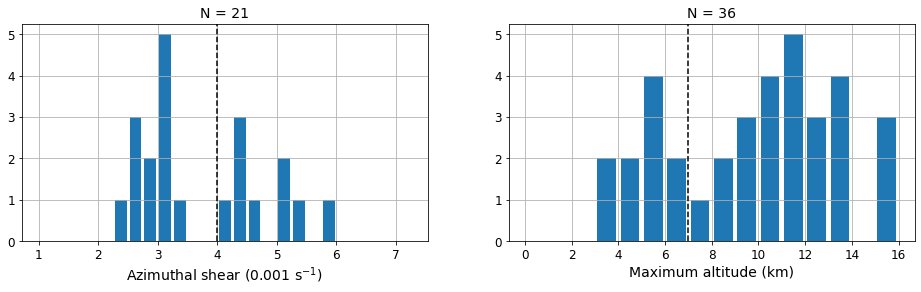

In [12]:
#PLot the filtered azi shear distribution and the maximum altitude distribution

plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
plt.hist(data.azi_shear30,rwidth=0.8,bins=np.arange(1,7.5,0.25),color="tab:blue")
plt.gca().grid()
plt.title("N = "+str((~data.azi_shear30.isna()).sum()),size=14)
plt.xlabel("Azimuthal shear (0.001 s$^{-1}$)",size=14)
plt.gca().tick_params(labelsize=12)
plt.gca().axvline(4,ls="--",color="k")

plt.subplot(1,2,2)
plt.hist(data.max_alt,rwidth=0.8,bins=np.arange(0,16.5,1),color="tab:blue")
plt.gca().grid()
plt.title("N = "+str((~data.max_alt.isna()).sum()),size=14)
plt.xlabel("Maximum altitude (km)",size=14)
plt.gca().tick_params(labelsize=12)
plt.gca().axvline(7,ls="--",color="k")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/tint_stats_distribution_2.jpeg",dpi=500,bbox_inches="tight")

/jobfs/50462245.gadi-pbs/ipykernel_622740/1809141667.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  stats_inst.aspect_ratio = stats_inst.major_axis_length/stats_inst.minor_axis_length


Text(0.5, 0, 'Convective pixel fraction')

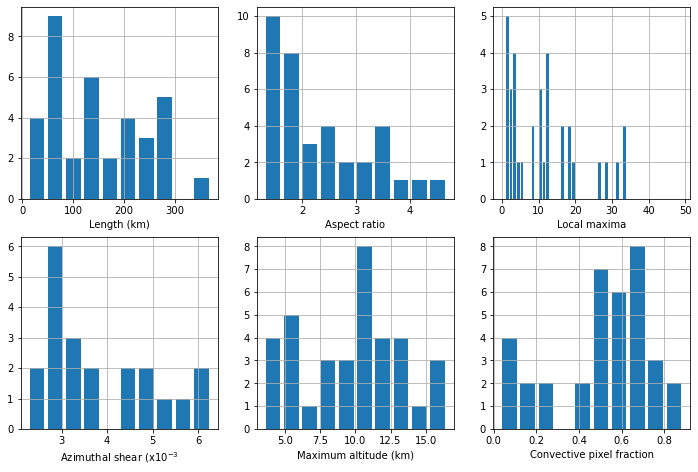

In [8]:
#PLot the other storm stat distributions

plt.figure(figsize=[12,12])
plt.subplot(3,3,1);stats_inst.major_axis_length.hist(rwidth=0.8); plt.xlabel("Length (km)")
stats_inst.aspect_ratio = stats_inst.major_axis_length/stats_inst.minor_axis_length
plt.subplot(3,3,2);stats_inst.aspect_ratio.hist(rwidth=0.8); plt.xlabel("Aspect ratio")
plt.subplot(3,3,3);stats_inst.local_max.hist(bins=np.arange(0,50,1),rwidth=0.8); plt.xlabel("Local maxima")
plt.subplot(3,3,4);stats_inst.azi_shear.hist(rwidth=0.8); plt.xlabel("Azimuthal shear (x10$^{-3}$")
plt.subplot(3,3,5);stats_inst.max_alt.hist(rwidth=0.8); plt.xlabel("Maximum altitude (km)")
plt.subplot(3,3,6);stats_inst.conv_pct.hist(rwidth=0.8); plt.xlabel("Convective pixel fraction")


4.562
6.112
4.188
4.25
4.009
5.145
5.75
5.062
5.821


/jobfs/50462245.gadi-pbs/ipykernel_622740/1617906983.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/azi_shear_structure.jpeg",quality=100,bbox_inches="tight")


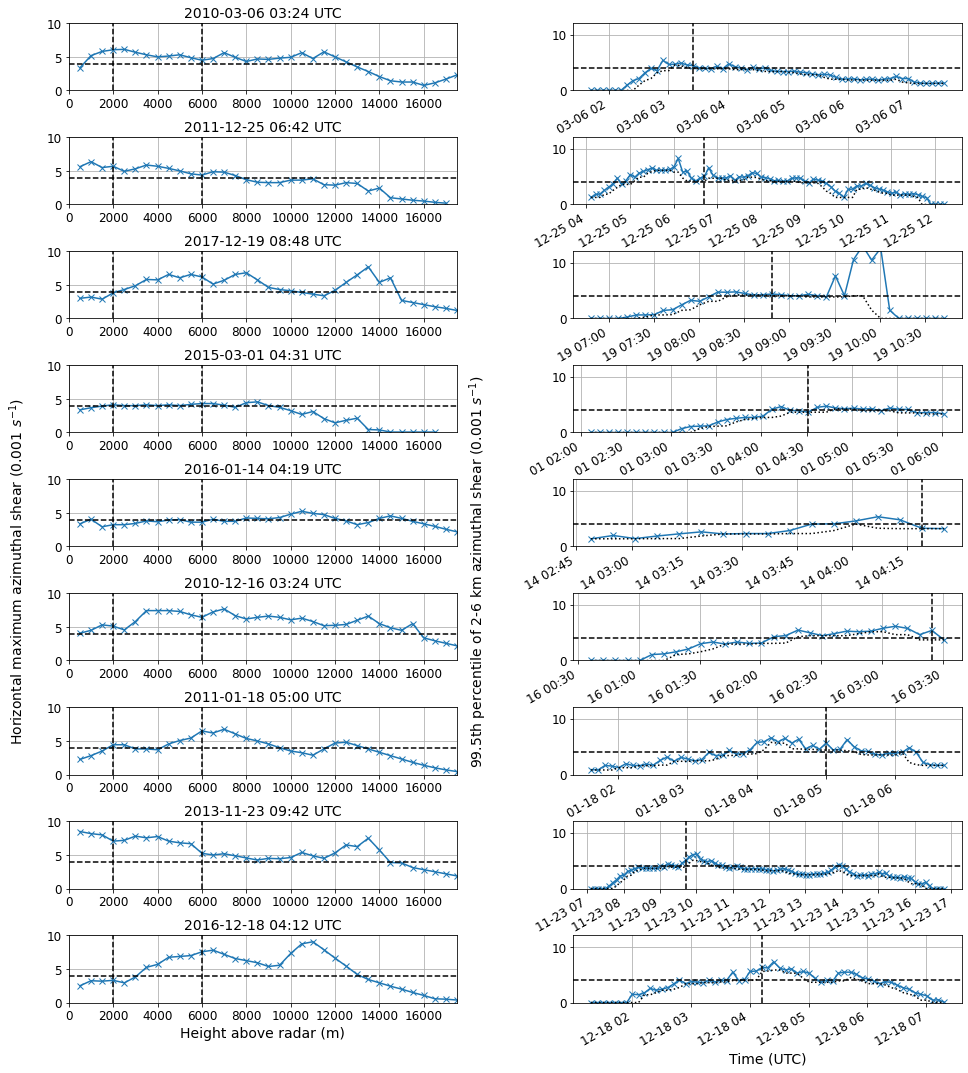

In [9]:
#DEPRECIATED: Azi_shear-height and azi_shear-time plots, for all storms with azi_shear > 4

cnt=1
fig=plt.figure(figsize=[16,20])
stats_inst["aspect_ratio"] = stats_inst["major_axis_length"]/stats_inst["minor_axis_length"]

for t in stats_inst.query("(azi_shear30>=4)").index:
    ax=plt.subplot(9,2,cnt)
    
    rid=stats_inst.loc[t].rid
    uid=stats_inst.loc[t].uid    
    temp = pd.read_csv(path+"/"+rid+"_"+(t+dt.timedelta(hours=-12)).strftime("%Y%m%d")+"_"+(t+dt.timedelta(hours=+12)).strftime("%Y%m%d")+".csv").query("uid=="+str(uid))
    
    scan_time=t
    radar = load_radar(rid, scan_time)
    file_id = rid+"_"+(scan_time+dt.timedelta(hours=-12)).strftime("%Y%m%d")+"_"+(scan_time+dt.timedelta(hours=+12)).strftime("%Y%m%d")
    h5 = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    r, x, y = reconstruct_grid(h5,scan_time.strftime("%Y%m%d%H%M%S")+"/"+str(uid))
    np.abs(xr.where(r==1,radar.azshear,np.nan).isel({"time":0})).max(("x","y")).plot(marker="x",ax=ax)
    ax.axhline(4,color="k",ls="--")
    ax.axvline(2000,color="k",ls="--")
    ax.axvline(6000,color="k",ls="--")
    ax.grid()    
    if cnt==17:
        ax.set_xlabel("Height above radar (m)",size=14)
        fig.text(0.08,0.5,"Horizontal maximum azimuthal shear (0.001 $s^{-1}$)",size=14,rotation="vertical",va="center",ha="center")#,transform=ax2.transAxes) 
    else:
        ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim([0,10])
    ax.set_title(t.strftime("%Y-%m-%d %H:%M")+" UTC",size=14)
    ax.tick_params(labelsize=12)
    ax.set_xlim([0,17500])
    
    ax2=plt.subplot(9,2,cnt+1)
    temp["time"] = pd.DatetimeIndex(temp.time)
    temp=temp.set_index("time")
    temp.azi_shear.plot(ax=ax2,marker="x")
    temp.azi_shear.rolling("30min",center=True,min_periods=2,closed="both").min().plot(ax=ax2, ls=":",color="k")
    print(temp.azi_shear.rolling("30min",center=True,min_periods=2,closed="both").min().max())
    
    ax2.axhline(4,color="k",ls="--")
    ax2.axvline(t,color="k",ls="--")    
    ax2.grid()
    if cnt==17:
        ax2.set_xlabel("Time (UTC)",size=14)
        fig.text(0.48,0.5,"99.5th percentile of 2-6 km azimuthal shear (0.001 $s^{-1}$)",size=14,rotation="vertical",va="center",ha="center")#,transform=ax2.transAxes)
    else:
        ax2.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,12])
    ax2.tick_params(labelsize=12)    
    
    cnt=cnt+2
    
plt.subplots_adjust(hspace=0.7,wspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/azi_shear_structure.jpeg",quality=100,bbox_inches="tight")

2010-03-06 03:24:32
4.562
2011-12-25 06:42:36
6.112
2017-12-19 08:48:28
4.188
2015-03-01 04:31:04
4.25
2016-01-14 04:19:00
4.009
2010-12-16 03:24:30
5.145
2011-01-18 05:00:22
5.75
2013-11-23 09:42:35
5.062
2016-12-18 04:12:47
5.821


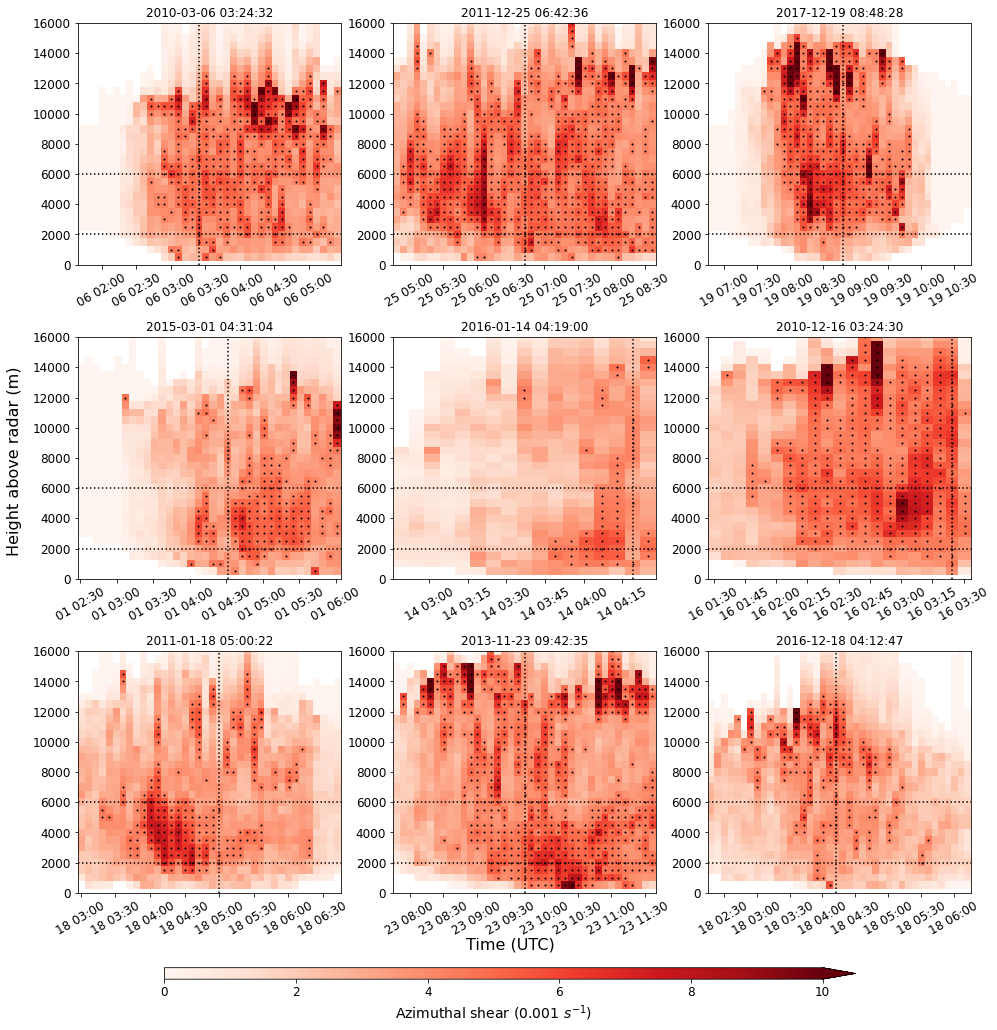

In [14]:
#Make a shaded time-height azi_shear plot

import warnings
warnings.simplefilter("ignore")

cnt=1
fig=plt.figure(figsize=[16,16])
stats_inst["aspect_ratio"] = stats_inst["major_axis_length"]/stats_inst["minor_axis_length"]

for t in stats_inst.query("(azi_shear30>=4)").index:

    print(t)
    ax=plt.subplot(3,3,cnt)


    rid=stats_inst.loc[t].rid
    uid=stats_inst.loc[t].uid    
    temp = pd.read_csv(path+"/"+rid+"_"+(t+dt.timedelta(hours=-12)).strftime("%Y%m%d")+"_"+(t+dt.timedelta(hours=+12)).strftime("%Y%m%d")+".csv").query("uid=="+str(uid))
    print(temp.set_index(pd.DatetimeIndex(temp.time)).azi_shear.rolling("30min",center=True,min_periods=2,closed="both").min().max())

    times = pd.DatetimeIndex(temp.time)
    times=times[(times>=(t+dt.timedelta(hours=-2))) & (times<=(t+dt.timedelta(hours=2)))]
    radar = load_radar_multiple(rid, [times[0]+dt.timedelta(seconds=-60),times[-1]+dt.timedelta(seconds=60)])
    file_id = rid+"_"+(t+dt.timedelta(hours=-12)).strftime("%Y%m%d")+"_"+(t+dt.timedelta(hours=+12)).strftime("%Y%m%d")
    h5 = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")        
    out_azshear = np.zeros((41,times.shape[0]))
    cnt2=0
    for scan_time in (times):
        r, x, y = reconstruct_grid(h5,scan_time.strftime("%Y%m%d%H%M%S")+"/"+str(uid))
        out_azshear[:,cnt2] = (xr.where(r==1,radar.sel({"time":scan_time}).azshear,np.nan)).max(("x","y")).values
        cnt2=cnt2+1

    z = radar.z.values    
    p = plt.pcolormesh(pd.to_datetime(times), z, out_azshear,cmap=plt.get_cmap("Reds"),vmin=0,vmax=10)
    sig_y,sig_x = np.where(out_azshear>=4)
    plt.plot(times[sig_x],z[sig_y],ls="none",marker="o",color="k",ms=1)
    ax.tick_params("x",labelsize=12,rotation=30) 
    ax.tick_params("y",labelsize=12) 
    ax.axvline(t,color="k",ls=":")
    ax.axhline(2000,color="k",ls=":")
    ax.axhline(6000,color="k",ls=":")
    ax.set_ylim([0,16000])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(t)

    cnt=cnt+1

cb=plt.colorbar(p, cax=plt.axes([0.2,0.05,0.6,0.01]), orientation="horizontal",extend="max")
cb.set_label("Azimuthal shear (0.001 $s^{-1}$)",size=14)
cb.ax.tick_params(labelsize=12)
fig.text(0.07,0.5,"Height above radar (m)",ha="center",va="center",size=16,rotation="vertical")
fig.text(0.5,0.08,"Time (UTC)",ha="center",va="center",size=16)
plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/azi_shear_time_height.jpeg",dpi=500,bbox_inches="tight")